In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

%matplotlib inline

In [184]:
#RandomForest Regression Algorithm
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

#Linear Regression Algorithm for Comparison
from sklearn.linear_model import LinearRegression

#Preprocessing Steps
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

#Pipeline
from sklearn.pipeline import Pipeline

#Cross Validation Score
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.decomposition import PCA

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans

In [3]:
import import_files as MrtRecommendationDependencies
from ridership_transformer import RidershipTransformer
import database
from database import TrainUpdate
from datetime import datetime

In [152]:
ridership_df = pd.read_csv(MrtRecommendationDependencies.get_dataset_path("cubao_transformed.csv"), parse_dates=['datetime'], index_col="datetime")
weather_df = pd.read_csv(MrtRecommendationDependencies.get_dataset_path("weather_filtered.csv"), parse_dates=['datetime'], index_col="datetime")
df_combined = ridership_df.join(weather_df, how="right")

In [153]:
query = TrainUpdate.filter(TrainUpdate.datetime != None)
train_updates = pd.read_sql(query.statement, query.session.bind)
train_updates.set_index("datetime", inplace=True)

In [154]:

df_combined = df_combined.join(train_updates, how="left")
df_combined.fillna(0, inplace=True)
with_train_updates = df_combined[df_combined.headway > 0]
with_train_updates = with_train_updates.drop('tweet_id', axis=1)
with_train_updates['hour_of_day'] = with_train_updates.apply(lambda x: x.name.hour, axis=1)
with_train_updates['day_of_week'] = with_train_updates.apply(lambda x: x.name.weekday(), axis=1)

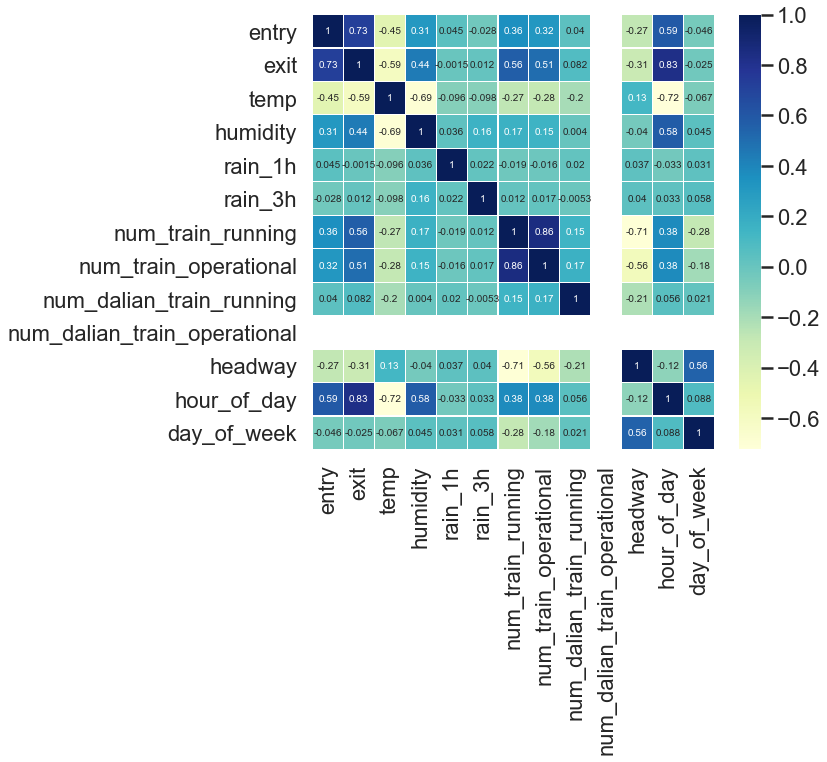

In [155]:
corrmat = with_train_updates.corr() 
  
f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1,annot=True) 

In [156]:
with_train_updates.head()
X = with_train_updates.drop(['weather_main', 'num_train_running', 'num_train_operational', 'num_dalian_train_running', 'num_dalian_train_operational', 'headway'], axis=1)
Y_train = with_train_updates['num_train_running']
Y_headway = with_train_updates['headway']

## Train Prediction Optimization

In [157]:
scaler = Normalizer()
regressor = RandomForestRegressor()

train_model = Pipeline([('scaler', scaler), ('regressor', regressor)])

grid_param_grid_train = {'regressor__random_state': [35],
                   'regressor__n_estimators': [*range(20,61)]
                  }

grid_search_train = GridSearchCV(train_model,param_grid=grid_param_grid_train,cv=5,scoring="r2")

In [158]:
grid_search_train.fit(X,Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', Normalizer()),
                                       ('regressor', RandomForestRegressor())]),
             param_grid={'regressor__n_estimators': [20, 21, 22, 23, 24, 25, 26,
                                                     27, 28, 29, 30, 31, 32, 33,
                                                     34, 35, 36, 37, 38, 39, 40,
                                                     41, 42, 43, 44, 45, 46, 47,
                                                     48, 49, ...],
                         'regressor__random_state': [35]},
             scoring='r2')

In [159]:
print(grid_search_train.best_estimator_)
print(grid_search_train.best_score_)

Pipeline(steps=[('scaler', Normalizer()),
                ('regressor',
                 RandomForestRegressor(n_estimators=57, random_state=35))])
0.6121325689749331


In [160]:
grid_search_train.cv_results_

{'mean_fit_time': array([0.06730742, 0.0588861 , 0.0615901 , 0.06594491, 0.06655073,
        0.07061915, 0.07187715, 0.07716546, 0.09217248, 0.08531981,
        0.08275118, 0.08970165, 0.09500642, 0.09144826, 0.09308972,
        0.09650893, 0.09988365, 0.10249224, 0.1044291 , 0.10727224,
        0.10910969, 0.11305733, 0.1161582 , 0.11704564, 0.12135496,
        0.12834635, 0.13329725, 0.12770958, 0.13266764, 0.13449616,
        0.13523917, 0.13755517, 0.13842201, 0.14094176, 0.14415202,
        0.15129566, 0.18104806, 0.20244393, 0.16208143, 0.16118484,
        0.16436543]),
 'std_fit_time': array([0.0137623 , 0.0006995 , 0.00070688, 0.00285375, 0.00041977,
        0.00293243, 0.0006676 , 0.00243514, 0.01028291, 0.00443988,
        0.00054113, 0.00777921, 0.00242452, 0.00265748, 0.00105574,
        0.0007904 , 0.00105247, 0.00058062, 0.00111637, 0.00165881,
        0.00095902, 0.00228497, 0.00232158, 0.00159962, 0.00084577,
        0.00500089, 0.0087083 , 0.00108481, 0.00219978, 0.003

### Headway

In [161]:
scaler = Normalizer()
regressor = RandomForestRegressor()

headway_model = Pipeline([('scaler', scaler), ('regressor', regressor)])

grid_param_grid_headway = { 'regressor': [RandomForestRegressor(), AdaBoostRegressor(), GradientBoostingRegressor()],
                   'regressor__random_state': [35],
                   'regressor__n_estimators': [*range(20,61)]
                  }

grid_search_headway = GridSearchCV(train_model,param_grid=grid_param_grid_headway,cv=5,scoring="r2")
X_headway = X.copy()
X_headway['num_train_running'] = Y_train

In [162]:
grid_search_headway.fit(X_headway, Y_headway)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', Normalizer()),
                                       ('regressor', RandomForestRegressor())]),
             param_grid={'regressor': [RandomForestRegressor(n_estimators=55,
                                                             random_state=35),
                                       AdaBoostRegressor(),
                                       GradientBoostingRegressor()],
                         'regressor__n_estimators': [20, 21, 22, 23, 24, 25, 26,
                                                     27, 28, 29, 30, 31, 32, 33,
                                                     34, 35, 36, 37, 38, 39, 40,
                                                     41, 42, 43, 44, 45, 46, 47,
                                                     48, 49, ...],
                         'regressor__random_state': [35]},
             scoring='r2')

In [163]:
print(grid_search_headway.best_estimator_)
print(grid_search_headway.best_score_)

Pipeline(steps=[('scaler', Normalizer()),
                ('regressor',
                 RandomForestRegressor(n_estimators=55, random_state=35))])
0.7142737273172604


In [164]:
train_df, test_df = train_test_split(with_train_updates, random_state=35, test_size=0.3)

In [165]:
def get_variables_and_target(df):
    x_df = df.drop(['weather_main', 'num_train_running', 'num_train_operational', 'num_dalian_train_running', 'num_dalian_train_operational', 'headway'], axis=1)
    y_train_df = df['num_train_running']
    y_headway_df = df['headway']
    return x_df, y_headway_df, y_train_df

In [166]:
x_train, train_train, headway_train = get_variables_and_target(train_df)

In [167]:
x_test, train_test, headaway_test = get_variables_and_target(test_df)

In [168]:
train_model = Pipeline([('scaler', Normalizer()), ('regressor', RandomForestRegressor(n_estimators=50, random_state=35))])
headway_model = Pipeline([('scaler', Normalizer()), ('regressor', RandomForestRegressor(n_estimators=50, random_state=35))])

In [169]:
train_model.fit(x_train, train_train)

Pipeline(steps=[('scaler', Normalizer()),
                ('regressor',
                 RandomForestRegressor(n_estimators=50, random_state=35))])

In [170]:
train_pred = train_model.predict(x_test)

In [171]:
x_headway_train = x_train.copy()

In [172]:
x_headway_train['num_train_running'] = train_train

In [173]:
headway_model.fit(x_headway_train, headway_train)

Pipeline(steps=[('scaler', Normalizer()),
                ('regressor',
                 RandomForestRegressor(n_estimators=50, random_state=35))])

In [174]:
x_headway_test = x_test.copy()

In [175]:
x_headway_test['num_train_running'] = train_pred

In [176]:
headway_pred = headway_model.predict(x_headway_test)

In [177]:
print(r2_score(train_test, train_pred))

0.5695738507937127


In [178]:
print(r2_score(headaway_test, headway_pred))

0.7491158381020693


In [179]:
with_train_updates

,entry,exit,temp,humidity,rain_1h,rain_3h,weather_main,num_train_running,num_train_operational,num_dalian_train_running,num_dalian_train_operational,headway,hour_of_day,day_of_week
datetime,,,,,,,,,,,,,,
2018-07-01 19:00:00,1865.0,3379.0,26.41,87,0.00,0.0,Haze,12.0,13.0,0.0,0,8.5,19,6
2018-07-02 05:00:00,1254.0,108.0,31.29,60,0.00,0.0,Haze,8.0,8.0,0.0,0,8.0,5,0
2018-07-02 18:00:00,2180.0,3415.0,27.23,84,0.00,0.0,Haze,15.0,15.0,0.0,0,7.0,18,0
2018-07-03 05:00:00,1255.0,172.0,30.09,66,0.00,0.0,Haze,7.0,7.0,0.0,0,8.0,5,1
2018-07-03 20:00:00,1502.0,2471.0,26.11,87,0.00,0.0,Haze,14.0,14.0,0.0,0,7.5,20,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-29 19:00:00,2222.0,4156.0,26.32,88,0.00,0.0,Haze,12.0,12.0,0.0,0,8.5,19,5
2019-06-30 06:00:00,590.0,444.0,30.94,70,0.00,0.0,Haze,12.0,12.0,0.0,0,8.5,6,6
2019-06-30 16:00:00,1522.0,2052.0,26.91,86,0.00,1.7,Rain,12.0,13.0,0.0,0,8.5,16,6


In [180]:
pca = PCA(n_components=2)

In [181]:
pca_data = pca.fit_transform(with_train_updates.drop('weather_main', axis=1))

In [182]:
pca_df = pd.DataFrame(data=pca_data, columns=["PCA1", "PCA2"])

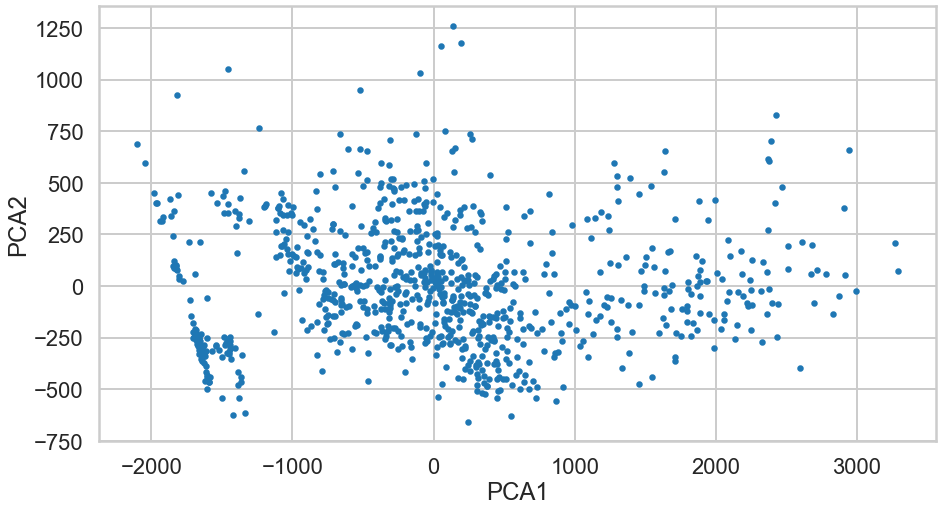

In [183]:
pca_df.plot(x='PCA1', y='PCA2', kind="scatter", figsize=(15,8))

In [80]:
pca.explained_variance_ratio_

array([0.93042319, 0.0694016 ])

In [84]:
pca_df.shape

(948, 2)

In [185]:
kmeans = KMeans(n_clusters=3, max_iter=1000, random_state=1)
kmeans.fit(pca_df)

KMeans(max_iter=1000, n_clusters=3, random_state=1)

In [186]:
pca_classified = pca_df.copy()
pca_classified['label'] =  kmeans.labels_

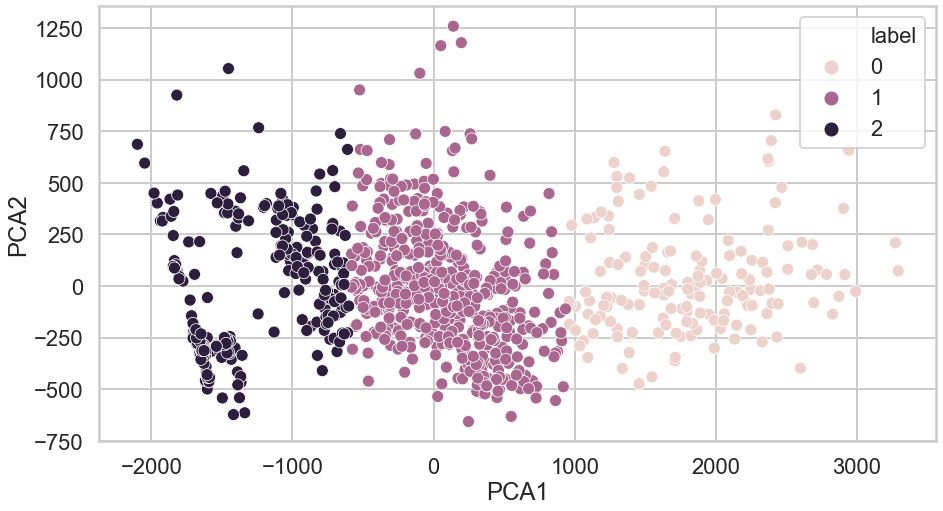

In [188]:
fig, ax = plt.subplots(figsize=(15,8))

sns.scatterplot(ax = ax, x=pca_classified.PCA1, y=pca_classified.PCA2, hue=pca_classified.label)